# Introduction
This notebook presents a cooling demand model (CDM) targeting the residential and office buildings in The Hague, The Netherlands. The primary aim is to serve as the computational base for Simon van Lierde's master's thesis in Industrial Ecology. The model incorporates data loading from from GIS files and public weather data APIs, extensive data processing, thermodynamic calculations, determination of environmental impacts, sensitivity analyses and the creation of figures.

## Import libraries

In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itables import init_notebook_mode

from functions.data_handling import (
    add_cooling_technology_data_to_buildings,
    add_parameters_to_buildings,
    aggregate_results,
    read_buildings,
    read_global_parameters,
    read_parameter_specific_data,
)
from functions.environmental import (
    calculate_environmental_impacts_from_cooling_demand,
    calculate_environmental_parameters_for_cooling_technologies,
)
from functions.figures import (
    get_indices_from_dates,
    plot_cooling_loads_for_building_types,
    plot_cooling_loads_for_energy_classes,
    plot_thermal_flows_for_building_types,
    plot_thermal_flows_for_energy_classes,
)
from functions.sensitivity_analysis import (
    normalize_SA_results,
    post_process_SA_cooling_tech_mix,
    post_process_SA_results,
    run_SA_for_cooling_technology_mix,
    run_SA_for_total_market_penetration,
    run_SA_for_variable_in_cooling_technology_parameters,
    run_SA_for_variable_in_global_parameters,
)
from functions.thermodynamic import calc_cooling_demand_metrics_for_df
from functions.time_series import create_time_series, get_raw_weather_data, read_dynamic_subsurface_temperature

# To improve interaction with DataFrames
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

# Calculate the cooling demand and its environmental impacts

### Set calculation options

In [3]:
BUILDING_SUBSET_NAME = "sample"  # The name of the subset of buildings to be used ('sample': 314 buildings, 'sample_2000': 2000 buildings, 'sample_5000': 5000 buildings, 'subset': 5000 buildings in the center of The Hague, or 'full': all buildings)')
SCENARIO = "SQ"  # The scenario to be used ('SQ' (Status Quo), '2030', 2050_L, '2050_M', 2050_H)
INCLUDE_TIME_SERIES_IN_DATAFRAME = (
    False  # Whether to include the time series in the DataFrame (True) or not (False). Should be set to false for large datasets to prevent memory issues
)
DROP_PARAMETER_COLUMNS = True  # Whether to drop the columns containing the parameters not needed for further analysis before writing to a file (True) or not (False)
PARAMETER_COLUMNS_TO_DROP_AFTER_CALCULATIONS = [  # The columns containing the parameters not needed for further analysis
    "avg_ADP_kgSbeq_kW",
    "avg_CSI_kgSieq_kW",
    "avg_GHG_emissions_electricity_kgCO2eq_kWh_cooling",
    "avg_GHG_emissions_EoL_phase_kgCO2eq_kW",
    "avg_GHG_emissions_production_phase_kgCO2eq_kW",
    "avg_GHG_emissions_refrigerant_leaks_kgCO2eq_kW",
    "avg_material_density_kg_kW",
    "avg_refrigerant_leakage_kg_kW",
    "avg_refrigerant_leakage_rate_relative",
    "energy_class_int",
    "energy_labels_included_residential",
    "energy_labels_included_office",
    "cooling_technology_share_ASHP",
    "cooling_technology_share_GSHP",
    "cooling_technology_share_WSHP",
    "cooling_technology_share_chiller",
    "cooling_technology_share_AC_split",
    "cooling_technology_share_AC_mobile",
    "f_wall",
    "f_window",
    "facade_area_per_orientation_m2",
    "g_window",
    "ground_elevation_m",
    "infiltration_ACH",
    "int_heat_gain_appliances_W_m2",
    "MBR_length_m",
    "MBR_width_m",
    "pressure_drop_Pa",
    "Rc_floor_m2K_W",
    "Rc_roof_m2K_W",
    "Rc_wall_m2K_W",
    "roof_elevation_m",
    "status",
    "U_window_W_m2K",
    "ventilation_rate_pp_m3_h",
    "wall_area_total_m2",
    "window_area_per_orientation_m2",
    "window_area_total_m2",
]

### Load data

#### Define path and layer names

In [4]:
# Building data
BAG_DATA_INPUT_PATH = Path(
    f"data/output/geodata/BAG_buildings_with_residence_data_{BUILDING_SUBSET_NAME}{'_'+SCENARIO if BUILDING_SUBSET_NAME == 'sample_2000' else ''}.gpkg",
)  # The path to the GeoPackage containing the BAG building data
BAG_DATA_LAYER_NAME = (
    f"BAG_buildings_{BUILDING_SUBSET_NAME}{'_'+SCENARIO if BUILDING_SUBSET_NAME == 'sample_2000' else ''}"  # The name of the layer containing the BAG building data
)

# Constant parameters
MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH = Path(
    "data/input/parameters/multidirectional_solar_radiation_fractions.csv",
)  # The file containing the multidirectional solar radiation fractions
PRESENCE_LOAD_FACTORS_PATH = Path("data/input/parameters/presence_load_factors.csv")  # The file containing the presence load factors

# Scenario-dependent parameters
SCENARIO_FOLDER = Path(f"data/input/parameters/parameters_{SCENARIO}")  # The folder containing the scenario specific parameters
PARAMETERS_GLOBAL_PATH = SCENARIO_FOLDER / Path("parameters_global.csv")  # The file containing the global parameters
PARAMETERS_BUILDING_TYPE_PATH = SCENARIO_FOLDER / Path("parameters_building_type.csv")  # The file containing the building type dependent parameters
PARAMETERS_ENERGY_CLASS_PATH = SCENARIO_FOLDER / Path("parameters_energy_class.csv")  # The file containing the energy class dependent parameters
PARAMETERS_COOLING_TECHNOLOGY_PATH = SCENARIO_FOLDER / Path("parameters_cooling_technology.csv")  # The file containing the cooling technology dependent parameters

# Sensitivity analysis
SUBSURFACE_TEMPERATURE_PATH = Path("data/input/parameters/subsurface_temperature.csv")  # The file containing the dynamic subsurface temperature series

# Outputs
RESULTS_GEODATA_OUTPUT_PATH = Path(
    f"data/output/geodata/buildings_with_CDM_results_{SCENARIO}_{BUILDING_SUBSET_NAME}.gpkg",
)  # The path to the file to which the results should be written
RESULTS_LAYER_NAME = f"buildings_with_CDM_results_{SCENARIO}_{BUILDING_SUBSET_NAME}"  # The name of the layer to which the results should be written
RESULTS_CSV_OUTPUT_PATH = Path(f"data/output/CDM_results_{SCENARIO}_{BUILDING_SUBSET_NAME}.csv")  # The path to the file to which the aggregated results should be written

#### Read data

In [5]:
# Load static parameters such as physical constants, building type- and energy label-dependant parameters
PARAMETERS_GLOBAL = read_global_parameters(PARAMETERS_GLOBAL_PATH)
PARAMETERS_BUILDING_TYPE = read_parameter_specific_data(PARAMETERS_BUILDING_TYPE_PATH)
PARAMETERS_ENERGY_CLASS = read_parameter_specific_data(PARAMETERS_ENERGY_CLASS_PATH)
PARAMETERS_COOLING_TECHNOLOGY = read_parameter_specific_data(PARAMETERS_COOLING_TECHNOLOGY_PATH)

# Load the building data containing the building geometries and simple building parameters
buildings = read_buildings(BAG_DATA_INPUT_PATH, BAG_DATA_LAYER_NAME)

# Fetch the raw weather data
raw_weather_data = get_raw_weather_data(PARAMETERS_GLOBAL)

#### Pre-process data

In [ ]:
# Assign the building parameters
buildings = add_parameters_to_buildings(buildings, PARAMETERS_GLOBAL, PARAMETERS_BUILDING_TYPE, PARAMETERS_ENERGY_CLASS)

# Build the cooling technologies DataFrame
cooling_technologies = calculate_environmental_parameters_for_cooling_technologies(PARAMETERS_COOLING_TECHNOLOGY, PARAMETERS_GLOBAL)

# Assign the cooling technology parameters to the buildings
buildings = add_cooling_technology_data_to_buildings(buildings, cooling_technologies)

# Create time series for weather series and other hourly data
time_series = create_time_series(PARAMETERS_GLOBAL, raw_weather_data, MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH, PRESENCE_LOAD_FACTORS_PATH)

### Calculate the cooling demand

In [ ]:
t_start = time.time()  # Start the timer

# Calculate the cooling demand in one go, including the cooling demand time series if INCLUDE_TIME_SERIES_IN_DATAFRAME is set to True
buildings = calc_cooling_demand_metrics_for_df(buildings, time_series, PARAMETERS_GLOBAL, INCLUDE_TIME_SERIES_IN_DATAFRAME)

t_end = time.time() - t_start  # Stop the timer

In [ ]:
# Print performance metrics
memory_usage = buildings.memory_usage(index=True).sum()
print("Memory usage:", round(memory_usage / 1024**2, 2), "MB, or ", round(memory_usage / 1024 / len(buildings), 2), "kb per building")
print("Time:", round(t_end, 2), "s, or ", round(t_end * 1000 / len(buildings), 2), "ms per building")

### Calculate the environmental impacts


In [ ]:
# Calculate the environmental impacts
buildings, impact_summary = calculate_environmental_impacts_from_cooling_demand(buildings, PARAMETERS_GLOBAL)

# Aggregate the results to the level of unique combinations of energy classes and building types
buildings_agg = aggregate_results(buildings, PARAMETERS_GLOBAL)

### Save results

In [ ]:
# Drop any columns that contain time series arrays for the sake of writing the DataFrame to a file
buildings_to_file = buildings.drop(
    columns=[col for col in buildings.columns if type(buildings[col].iloc[0]) == np.ndarray],
)

# Drop the parameter columns (those that are not used in further analysis) if DROP_PARAMETER_COLUMNS is set to True
if DROP_PARAMETER_COLUMNS:
    # Check which parameter columns are in the DataFrame
    columns_to_drop_existing = [col for col in PARAMETER_COLUMNS_TO_DROP_AFTER_CALCULATIONS if col in buildings_to_file.columns]

    # Drop the parameter columns that are in the DataFrame
    buildings_to_file = buildings_to_file.drop(columns=columns_to_drop_existing)

# Save buildings with CDM results to GeoPackage
buildings_to_file.to_file(RESULTS_GEODATA_OUTPUT_PATH, layer=RESULTS_LAYER_NAME, driver="GPKG")

# Save aggregated results to csv file
buildings_agg.to_csv(RESULTS_CSV_OUTPUT_PATH, index=False)

# Sensitivity analysis

In [9]:
# Load the global parameters for all scenarios, for plotting purposes
global_param_dict = {}

for scenario in ["SQ", "2030", "2050_L", "2050_M", "2050_H"]:
    global_parameter_path = Path(f"data/input/parameters/parameters_{scenario}/parameters_global.csv")  # The file containing the global parameters for that scenario
    global_param_dict[scenario] = read_global_parameters(global_parameter_path)  # Load the global parameters for the scenario into the dictionary

### Create a sample of the BAG for easier sensitivity analysis

#### Proportional to the total building stock

In [ ]:
# Count the amount of buildings per combination of building type and energy class
buildings_per_building_type_and_energy_class = buildings.groupby(["building_type", "building_type_int", "energy_class"]).size().reset_index(name="count")

# Calculate the fraction of buildings per combination of building type and energy class
buildings_per_building_type_and_energy_class["fraction"] = buildings_per_building_type_and_energy_class["count"] / buildings_per_building_type_and_energy_class["count"].sum()

In [ ]:
sample_size_total = 2000  # The total number of buildings to sample
sample_size_per_building_type_and_energy_class_minimum = 1  # The minimum number of buildings to sample per building type and energy class
building_sample_output_path = f"data/output/geodata/BAG_buildings_with_residence_data_sample_2000_{SCENARIO}.gpkg"  # The path to the output file containing the sample of buildings
building_sample_layer_name = f"BAG_buildings_sample_2000_{SCENARIO}"  # The name of the layer in the output file containing the sample of buildings
buildings_sample = None  # The DataFrame containing the sample of buildings

# Loop over the building type - energy class combinations
for _, row in buildings_per_building_type_and_energy_class.iterrows():
    # Calculate the sample size for this combination of building type and energy class
    sample_size = max(round(row["fraction"] * sample_size_total), sample_size_per_building_type_and_energy_class_minimum)

    # Now take a random sample of size n from the buildings DataFrame within this combination of building type and energy class
    buildings_subset = buildings[(buildings["building_type"] == row["building_type"]) & (buildings["energy_class"] == row["energy_class"])]
    sample_subset = buildings_subset.sample(n=len(buildings_subset) if len(buildings_subset) < sample_size else sample_size)

    # Now add this DataFrame to the sample DataFrame
    buildings_sample = pd.concat([buildings_sample, sample_subset])

# Reset the index of the buildings_subset_df DataFrame
buildings_sample = buildings_sample.reset_index(drop=True)

# Drop all columns that are dependent on scenario parameters
buildings_sample = buildings_sample.drop(buildings.columns[18:], axis=1)

# Write the subset of buildings to a GeoPackage file
buildings_sample.to_file(building_sample_output_path, layer=building_sample_layer_name, driver="GPKG")

#### Equally sized samples per building type

In [ ]:
sample_size_per_building_type = 250  # The total number of buildings to sample per building type
building_sample_output_path = (
    "data/output/geodata/BAG_buildings_with_residence_data_sample_2000_equal_bins_building_types.gpkg"  # The path to the output file containing the sample of buildings
)
building_sample_layer_name = "BAG_buildings_sample_2000_equal_bins_building_types"  # The name of the layer in the output file containing the sample of buildings
buildings_sample = None  # The DataFrame containing the sample of buildings

# Loop over the building types
for building_type in buildings["building_type"].unique():
    # Now take a random sample of size n from the buildings DataFrame within this building type
    buildings_subset = buildings[(buildings["building_type"] == building_type)]
    sample_subset = buildings_subset.sample(n=len(buildings_subset) if len(buildings_subset) < sample_size_per_building_type else sample_size_per_building_type)

    # Now add this DataFrame to the sample DataFrame
    buildings_sample = pd.concat([buildings_sample, sample_subset])

# Reset the index of the buildings_subset_df DataFrame
buildings_sample = buildings_sample.reset_index(drop=True)

# Drop all columns that are dependent on scenario parameters
buildings_sample = buildings_sample.drop(buildings.columns[18:], axis=1)

# Write the subset of buildings to a GeoPackage file
buildings_sample.to_file(building_sample_output_path, layer=building_sample_layer_name, driver="GPKG")

### Compare impacts of scenarios

In [ ]:
impact_summaries = {}

for scenario in ["SQ", "2030", "2050_L", "2050_M", "2050_H"]:
    # Scenario-dependent parameters
    SCENARIO_FOLDER = Path(f"data/input/parameters/parameters_{scenario}")  # The folder containing the scenario specific parameters
    PARAMETERS_GLOBAL_PATH = SCENARIO_FOLDER / Path("parameters_global.csv")  # The file containing the global parameters
    PARAMETERS_BUILDING_TYPE_PATH = SCENARIO_FOLDER / Path("parameters_building_type.csv")  # The file containing the building type dependent parameters
    PARAMETERS_ENERGY_CLASS_PATH = SCENARIO_FOLDER / Path("parameters_energy_class.csv")  # The file containing the energy class dependent parameters
    PARAMETERS_COOLING_TECHNOLOGY_PATH = SCENARIO_FOLDER / Path("parameters_cooling_technology.csv")  # The file containing the cooling technology dependent parameters

    # Load static parameters such as physical constants, building type- and energy label-dependant parameters
    PARAMETERS_GLOBAL = read_global_parameters(PARAMETERS_GLOBAL_PATH)
    PARAMETERS_BUILDING_TYPE = read_parameter_specific_data(PARAMETERS_BUILDING_TYPE_PATH)
    PARAMETERS_ENERGY_CLASS = read_parameter_specific_data(PARAMETERS_ENERGY_CLASS_PATH)
    PARAMETERS_COOLING_TECHNOLOGY = read_parameter_specific_data(PARAMETERS_COOLING_TECHNOLOGY_PATH)

    # Load the building data containing the building geometries and simple building parameters
    buildings = read_buildings(BAG_DATA_INPUT_PATH, BAG_DATA_LAYER_NAME)

    # Assign the building parameters
    buildings = add_parameters_to_buildings(buildings, PARAMETERS_GLOBAL, PARAMETERS_BUILDING_TYPE, PARAMETERS_ENERGY_CLASS)

    # Build the cooling technologies DataFrame
    cooling_technologies = calculate_environmental_parameters_for_cooling_technologies(PARAMETERS_COOLING_TECHNOLOGY, PARAMETERS_GLOBAL)

    # Assign the cooling technology parameters to the buildings
    buildings = add_cooling_technology_data_to_buildings(buildings, cooling_technologies)

    # Create time series for weather series and other hourly data
    time_series = create_time_series(PARAMETERS_GLOBAL, raw_weather_data, MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH, PRESENCE_LOAD_FACTORS_PATH)

    # Calculate the cooling demand in one go, including the cooling demand time series if INCLUDE_TIME_SERIES_IN_DATAFRAME is set to True
    buildings = calc_cooling_demand_metrics_for_df(buildings, time_series, PARAMETERS_GLOBAL, INCLUDE_TIME_SERIES_IN_DATAFRAME)

    # Calculate the environmental impacts
    buildings, impact_summary = calculate_environmental_impacts_from_cooling_demand(buildings, PARAMETERS_GLOBAL)
    impact_summaries[scenario] = impact_summary

## Comfort Optimization Assessments

### Effective cooling temperature
Analyze the influence of the effective cooling temperature (or threshold temperature) on the energy demand, GHG emissions and material demand

In [ ]:
# Fetch the value for T_thresh_C for all scenarios
reference_values_T_thresh_C = {
    "SQ": global_param_dict["SQ"]["T_thresh_C"],
    "2030": global_param_dict["2030"]["T_thresh_C"],
    "2050_L": global_param_dict["2050_L"]["T_thresh_C"],
    "2050_M": global_param_dict["2050_M"]["T_thresh_C"],
    "2050_H": global_param_dict["2050_H"]["T_thresh_C"],
}

In [ ]:
# Run sensitivity analysis for the T_thresh_C parameter (the effective cooling temperature)
SA_results_T_thresh_C = run_SA_for_variable_in_global_parameters(
    variable_name="T_thresh_C",
    variable_start=15,
    variable_end=30,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=200,
)

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_T_thresh_C,
    reference_values=reference_values_T_thresh_C,
    variable_name_print="effective cooling temperature",
    variable_unit_print="°C",
    round_to=0,
    include_scenario_lines_in_plots=True,
)

### Cooling demand cap percentile
Analyze the influence of the percentile at which the cooling demand is capped on the energy demand, GHG emissions and material demand

In [ ]:
# Run sensitivity analysis
SA_results_cooling_demand_cap_percentile = run_SA_for_variable_in_global_parameters(
    variable_name="peak_cooling_percentile_cap",
    variable_start=80,
    variable_end=99.9,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=250,
)

In [ ]:
# Fetch the value for the cooling demand cap percentile for all scenarios
reference_values_cooling_demand_cap_percentile = {
    "SQ": global_param_dict["SQ"]["peak_cooling_percentile_cap"],
    "2030": global_param_dict["2030"]["peak_cooling_percentile_cap"],
    "2050_L": global_param_dict["2050_L"]["peak_cooling_percentile_cap"],
    "2050_M": global_param_dict["2050_M"]["peak_cooling_percentile_cap"],
    "2050_H": global_param_dict["2050_H"]["peak_cooling_percentile_cap"],
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_cooling_demand_cap_percentile,
    reference_values=reference_values_cooling_demand_cap_percentile,
    variable_name_print="cooling power cap percentile",
    variable_unit_print="%",
    round_to=0,
    include_scenario_lines_in_plots=False,
)

## Climate-impact sensitivity analyses

### UHI effect
Analyze the influence of the UHI effect (both night and day values) on the energy demand, GHG emissions and material demand

#### UHI effect (day)

In [7]:
# Run sensitivity analysis for the UHI effect during the day

SA_results_UHI_effect_day = run_SA_for_variable_in_global_parameters(
    variable_name="UHI_effect_day_C",
    variable_start=0,
    variable_end=15,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=100,
)

100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


In [13]:
SA_results_UHI_effect_day

Cooling energy demand (kWh/m2)  Peak cooling power demand (W/m2)  \
0.000000                         13.13138                          16.78324   
0.151515                         13.41166                          17.07964   
0.303030                         13.69844                          17.37931   
0.454545                         13.99184                          17.68238   
0.606061                         14.29205                          17.98951   
...                                   ...                               ...   
14.393939                        80.72048                          52.01300   
14.545455                        81.92328                          52.40332   
14.696970                        83.13726                          52.79363   
14.848485                        84.36265                          53.18391   
15.000000                        85.59938                          53.57420   

           Electricity use (kWh/m2)  GHG emissions (kg CO2eq/m2)  \
0.000000                    0.82839                      0.44811   
0.151515                    0.84352                      0.45608   
0.303030                    0.85896                      0.46420   
0.454545                    0.87471                      0.47246   
0.606061                    0.89078                      0.48089   
...                             ...                          ...   
14.393939                   4.13804                      2.03743   
14.545455                   4.19490                      2.06366   
14.696970                   4.25224                      2.09009   
14.848485                   4.31008                      2.11673   
15.000000                   4.36841                      2.14358   

           Material demand (kg/m2)  
0.000000                   0.04344  
0.151515                   0.04411  
0.303030                   0.04479  
0.454545                   0.04547  
0.606061                   0.04616  
...                            ...  
14.393939                  0.12094  
14.545455                  0.12179  
14.696970                  0.12265  
14.848485                  0.12350  
15.000000                  0.12436  

[100 rows x 5 columns]

In [15]:
13.13138	/41.21498

0.318606972513392

In [10]:
# Fetch the value for UHI_effect_day_C for all scenarios
reference_values_UHI_effect_day = {
    "SQ": global_param_dict["SQ"]["UHI_effect_day_C"],
    "2030": global_param_dict["2030"]["UHI_effect_day_C"],
    "2050_L": global_param_dict["2050_L"]["UHI_effect_day_C"],
    "2050_M": global_param_dict["2050_M"]["UHI_effect_day_C"],
    "2050_H": global_param_dict["2050_H"]["UHI_effect_day_C"],
}

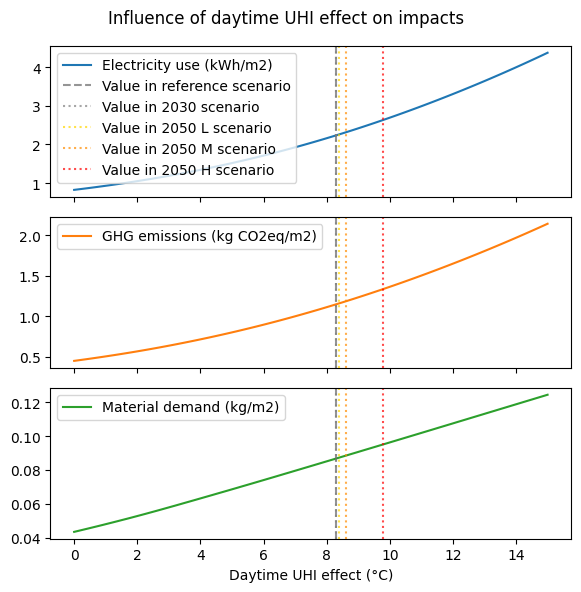

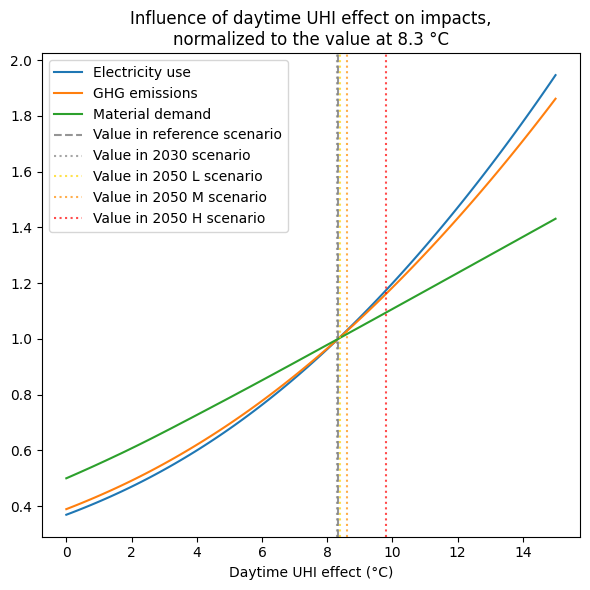

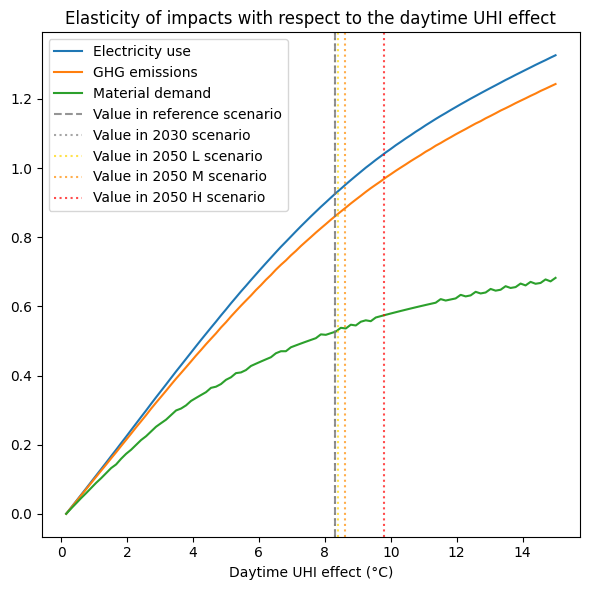

The elasticities of the cooling demand and environmental impacts with respect to the daytime UHI effect at 8 °C are:


Cooling energy demand        1.037752
Peak cooling power demand    0.575742
Electricity use              0.927524
GHG emissions                0.862422
Material demand              0.527074
Name: 8.333333333333334, dtype: float64

In [14]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_UHI_effect_day,
    reference_values=reference_values_UHI_effect_day,
    variable_name_print="daytime UHI effect",
    variable_unit_print="°C",
    round_to=1,
    include_scenario_lines_in_plots=True,
)

Investigate the difference in impact between the UHI effect on a hot summer's day (8.3 °C) and the annual average daytime UHI effect (1.2 °C)

In [ ]:
# Find the variable value in the sensitivity analysis closest to the reference value
ref_value_in_SA_results_UHI_effect_day = SA_results_UHI_effect_day.index[(np.abs(SA_results_UHI_effect_day.index - PARAMETERS_GLOBAL["UHI_effect_day_C"])).argmin()]

# Normalize the results to the value used for the independent variable in the reference scenario
SA_results_UHI_effect_day_normalized = normalize_SA_results(SA_results_UHI_effect_day, ref_value_in_SA_results_UHI_effect_day)

In [ ]:
variable_name_print_UHI_effect_day = "daytime UHI effect"
variable_unit_print_UHI_effect_day = "°C"
x_axis_label_UHI_effect_day = variable_name_print_UHI_effect_day[0].upper() + variable_name_print_UHI_effect_day[1:] + f" ({variable_unit_print_UHI_effect_day})"

In [ ]:
SA_results_UHI_effect_day.iloc[:, -3:].plot(subplots=True, figsize=(9, 6), sharex=True)  # Initialize the plot
plt.suptitle("Influence of daytime UHI effect on impacts")  # Add a title to the plot
for ax in plt.gcf().axes:  # Add the line indicating the reference value in each subplot
    ax.axvline(
        x=reference_values_UHI_effect_day["SQ"], color="dimgray", linestyle="dotted", alpha=0.7, label="Value in reference scenario:\nUHI effect on a hot summer's day (8.3 °C)"
    )
    ax.axvline(x=1.2, color="green", linestyle="dotted", alpha=0.7, label="Annual average daytime UHI effect (1.2 °C)")
plt.gcf().axes[0].legend(
    bbox_to_anchor=(1, 1),
    loc="upper right",
    # borderaxespad=0,
)  # Add a legend for the reference value to the first subplot
plt.xlabel(x_axis_label_UHI_effect_day)  # Add the x-axis label
plt.tight_layout()  # Make sure the subplots don't overlap
plt.savefig(f"data/output/images/SA/SA_results_{variable_name_print_UHI_effect_day.replace(' ', '_')}_with_1_2_C_line.png", dpi=300, bbox_inches="tight")  # Save the figure
plt.show()  # Show the plot to the console
plt.close()

In [ ]:
SA_results_UHI_effect_day_normalized.iloc[:, -3:].plot(subplots=False, figsize=(6, 6), sharex=True)  # Initialize the plot
plt.title(f"Influence of {variable_name_print_UHI_effect_day} on impacts,\nnormalized to the value at 8.3 °C")  # Add a title to the plot
plt.axvline(
    x=reference_values_UHI_effect_day["SQ"], color="dimgray", linestyle="dotted", alpha=0.7, label="Value in reference scenario:\nUHI effect on a hot summer's day (8.3 °C)"
)
plt.axvline(x=reference_values_UHI_effect_day["2030"], color="dimgray", linestyle="dotted", alpha=0.7, label="Value in 2050 L scenario")
plt.axvline(x=reference_values_UHI_effect_day["2050_L"], color="gold", linestyle="dotted", alpha=0.7, label="Value in 2050 L scenario")
plt.axvline(x=reference_values_UHI_effect_day["2050_M"], color="darkorange", linestyle="dotted", alpha=0.7, label="Value in 2050 M scenario")
plt.axvline(x=reference_values_UHI_effect_day["2050_H"], color="red", linestyle="dotted", alpha=0.7, label="Value in 2050 H scenario")
plt.axvline(x=1.2, color="green", linestyle="dotted", alpha=0.7, label="Annual average daytime UHI effect (1.2 °C)")
plt.xlabel(x_axis_label_UHI_effect_day)  # Add the x-axis label
plt.legend()  # Add a legend to the plot
plt.tight_layout()  # Make sure the subplots don't overlap
plt.savefig(
    f"data/output/images/SA/SA_results_{variable_name_print_UHI_effect_day.replace(' ', '_')}_normalized_with_1_2_C_line.png",
    dpi=300,
    bbox_inches="tight",
)  # Save the figure
plt.show()  # Show the plot to the console
plt.close()

#### UHI effect (night)

In [ ]:
# Run sensitivity analysis for the UHI effect during the night
SA_results_UHI_effect_night = run_SA_for_variable_in_global_parameters(
    variable_name="UHI_effect_night_C",
    variable_start=0,
    variable_end=15,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=100,
)

In [ ]:
# Fetch the value for UHI_effect_night_C for all scenarios
reference_values_UHI_effect_night_C = {
    "SQ": global_param_dict["SQ"]["UHI_effect_night_C"],
    "2030": global_param_dict["2030"]["UHI_effect_night_C"],
    "2050_L": global_param_dict["2050_L"]["UHI_effect_night_C"],
    "2050_M": global_param_dict["2050_M"]["UHI_effect_night_C"],
    "2050_H": global_param_dict["2050_H"]["UHI_effect_night_C"],
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_UHI_effect_night,
    reference_values=reference_values_UHI_effect_night_C,
    variable_name_print="nighttime UHI effect",
    variable_unit_print="°C",
    round_to=1,
    include_scenario_lines_in_plots=True,
)

### Outside air temperature increase

#### Springtime temperature shift

In [ ]:
# Run sensitivity analysis for the springtime temperature shift
SA_results_delta_T_spring = run_SA_for_variable_in_global_parameters(
    variable_name="delta_T_spring_C",
    variable_start=0,
    variable_end=4,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_delta_T_spring,
    reference_value=PARAMETERS_GLOBAL["delta_T_spring_C"],
    variable_name_print="springtime temperature shift",
    variable_unit_print="°C",
    round_to=1,
)

#### Summertime temperature

In [ ]:
# Run sensitivity analysis for the summertime temperature shift
SA_results_T_summer = run_SA_for_variable_in_global_parameters(
    variable_name="delta_T_summer_C",
    variable_start=-2,
    variable_end=8,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=100,
)

In [ ]:
# Fetch the average temperature during summer months from the raw weather data
average_T_summer_C = raw_weather_data[raw_weather_data["date"].dt.month.isin([6, 7, 8])]["T_outdoor_raw_C"].mean()

# Adding the average temperature during summer months to the index of the SA results DataFrame
SA_results_T_summer = SA_results_T_summer.set_index(SA_results_T_summer.index + average_T_summer_C)

In [ ]:
# Fetch the value for the summer temperature for all scenarios
reference_values_T_summer = {
    "SQ": global_param_dict["SQ"]["delta_T_summer_C"] + average_T_summer_C,
    "2030": global_param_dict["2030"]["delta_T_summer_C"] + average_T_summer_C,
    "2050_L": global_param_dict["2050_L"]["delta_T_summer_C"] + average_T_summer_C,
    "2050_M": global_param_dict["2050_M"]["delta_T_summer_C"] + average_T_summer_C,
    "2050_H": global_param_dict["2050_H"]["delta_T_summer_C"] + average_T_summer_C,
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_T_summer,
    reference_values=reference_values_T_summer,
    variable_name_print="average summertime temperature",
    variable_unit_print="°C",
    round_to=1,
)

#### Autumn time temperature shift

In [ ]:
# Run sensitivity analysis for the autumn time temperature shift
SA_results_delta_T_autumn = run_SA_for_variable_in_global_parameters(
    variable_name="delta_T_autumn_C",
    variable_start=0,
    variable_end=4,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_delta_T_autumn,
    reference_value=PARAMETERS_GLOBAL["delta_T_autumn_C"],
    variable_name_print="autumn-time temperature shift",
    variable_unit_print="°C",
    round_to=1,
)

#### Wintertime temperature shift

In [ ]:
# Run sensitivity analysis for the wintertime temperature shift
SA_results_delta_T_winter = run_SA_for_variable_in_global_parameters(
    variable_name="delta_T_winter_C",
    variable_start=0,
    variable_end=4,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_delta_T_winter,
    reference_value=PARAMETERS_GLOBAL["delta_T_winter_C"],
    variable_name_print="wintertime temperature shift",
    variable_unit_print="°C",
    round_to=1,
)

### Solar radiation

#### Solar radiation during summer

In [ ]:
# Run sensitivity analysis for the solar radiation during summer
SA_results_solar_radiation_summer = run_SA_for_variable_in_global_parameters(
    variable_name="delta_P_solar_summer",
    variable_start=-0.01,
    variable_end=0.1,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Fetch the average solar radiation during summer months from the reference time series
time_series_df = pd.DataFrame(time_series)
average_solar_radiation_summer_W_m2 = time_series_df[time_series_df["date"].dt.month.isin([6, 7, 8])]["P_sol_total_W_m2"].mean()

# Adding the average_solar_radiation_summer_W_m2 to the index of SA_results_solar_radiation_summer
SA_results_solar_radiation_summer = SA_results_solar_radiation_summer.set_index((SA_results_solar_radiation_summer.index + 1) * average_solar_radiation_summer_W_m2)

In [ ]:
# Fetch the value for the solar radiation during summer months for all scenarios
reference_values_solar_radiation_summer = {
    "SQ": (global_param_dict["SQ"]["delta_P_solar_summer"] + 1) * average_solar_radiation_summer_W_m2,
    "2030": (global_param_dict["2030"]["delta_P_solar_summer"] + 1) * average_solar_radiation_summer_W_m2,
    "2050_L": (global_param_dict["2050_L"]["delta_P_solar_summer"] + 1) * average_solar_radiation_summer_W_m2,
    "2050_M": (global_param_dict["2050_M"]["delta_P_solar_summer"] + 1) * average_solar_radiation_summer_W_m2,
    "2050_H": (global_param_dict["2050_H"]["delta_P_solar_summer"] + 1) * average_solar_radiation_summer_W_m2,
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_solar_radiation_summer,
    reference_values=reference_values_solar_radiation_summer,
    variable_name_print="average summertime solar radiation",
    variable_unit_print="W/m2",
    round_to=1,
)

#### Solar radiation during the rest of the year

In [ ]:
# Run sensitivity analysis for the solar radiation during the rest of the year
SA_results_solar_radiation_RoY = run_SA_for_variable_in_global_parameters(
    variable_name="delta_P_solar_RoY",
    variable_start=-0.01,
    variable_end=0.1,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Fetch the average solar radiation during the rest of the year from the reference time series
time_series_df = pd.DataFrame(time_series)
average_solar_radiation_RoY_W_m2 = time_series_df[~time_series_df["date"].dt.month.isin([6, 7, 8])]["P_sol_total_W_m2"].mean()

# Adding the average_solar_radiation_RoY_W_m2 to the index of average_solar_radiation_RoY_W_m2
SA_results_solar_radiation_RoY = SA_results_solar_radiation_RoY.set_index((SA_results_solar_radiation_RoY.index + 1) * average_solar_radiation_RoY_W_m2)

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_solar_radiation_RoY,
    reference_value=((PARAMETERS_GLOBAL["delta_P_solar_RoY"] + 1) * average_solar_radiation_RoY_W_m2),
    variable_name_print="average rest-of-year solar radiation",
    variable_unit_print="W/m2",
    round_to=1,
)

### Subsurface temperature: static vs dynamic
Analysis on the difference in environmental impacts between using a static subsurface temperature vs. using a time-series as input for the CDM

In [ ]:
# Fetch the total cooling energy and power demands calculated with the static subsurface temperature series
E_cooling_kWh_total_static_T_sub_C = buildings["E_cooling_kWh"].sum()
P_cooling_peak_kW_total_static_T_sub_C = buildings["P_cooling_peak_kW"].sum()

# Read the dynamic subsurface temperature series for the reference period
subsurface_T_dynamic = read_dynamic_subsurface_temperature(SUBSURFACE_TEMPERATURE_PATH, 2018, 2022)

# Create a copy of PARAMETERS_GLOBAL in which T_sub_C is changed to a dynamic subsurface temperature series
global_parameters_with_dynamic_T_sub_C = PARAMETERS_GLOBAL.copy()
global_parameters_with_dynamic_T_sub_C["T_sub_C"] = subsurface_T_dynamic

# Calculate the cooling demand using the dynamic subsurface temperature series
buildings_with_dynamic_T_sub_C = calc_cooling_demand_metrics_for_df(buildings, time_series, global_parameters_with_dynamic_T_sub_C)

# Read the energy and power demand using the dynamic subsurface temperature series
E_cooling_kWh_total_dynamic_T_sub_C = buildings_with_dynamic_T_sub_C["E_cooling_kWh"].sum()
P_cooling_peak_kW_total_dynamic_T_sub_C = buildings_with_dynamic_T_sub_C["P_cooling_peak_kW"].sum()

# Calculate the relative difference between the total cooling energy and power demands calculated with the dynamic and static subsurface temperature series
E_cooling_kWh_total_relative_difference = (E_cooling_kWh_total_dynamic_T_sub_C - E_cooling_kWh_total_static_T_sub_C) / E_cooling_kWh_total_static_T_sub_C
P_cooling_peak_kW_total_relative_difference = (P_cooling_peak_kW_total_dynamic_T_sub_C - P_cooling_peak_kW_total_static_T_sub_C) / P_cooling_peak_kW_total_static_T_sub_C

# Print the results
print(f"Total cooling energy demand with dynamic subsurface temperature series: {round(E_cooling_kWh_total_dynamic_T_sub_C / 1_000_000, 2):,} GWh")
print(f"Total cooling energy demand with static subsurface temperature series: {round(E_cooling_kWh_total_static_T_sub_C / 1_000_000, 2):,} GWh")
print(f"Difference in total energy demand: {round(E_cooling_kWh_total_relative_difference * 100, 2):,} %")

print(f"Total cooling power demand with dynamic subsurface temperature series: {round(P_cooling_peak_kW_total_dynamic_T_sub_C / 1_000, 2):,} MW")
print(f"Total cooling power demand with static subsurface temperature series: {round(P_cooling_peak_kW_total_static_T_sub_C / 1_000, 2):,} MW")
print(f"Difference in total power demand: {round(P_cooling_peak_kW_total_relative_difference * 100, 2):,} %")

## Carbon efficiency sensitivity analyses

#### Carbon intensity of electric grid

In [ ]:
# Run sensitivity analysis for the carbon intensity of the electricity grid
SA_results_carbon_intensity_grid = run_SA_for_variable_in_global_parameters(
    variable_name="carbon_intensity_electric_grid_kgCO2eq_kWh",
    variable_start=0,
    variable_end=1,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Fetch the value for grid carbon intensities for all scenarios
reference_values_carbon_intensity_electric_grid = {
    "SQ": global_param_dict["SQ"]["carbon_intensity_electric_grid_kgCO2eq_kWh"],
    "2030": global_param_dict["2030"]["carbon_intensity_electric_grid_kgCO2eq_kWh"],
    "2050_L": global_param_dict["2050_L"]["carbon_intensity_electric_grid_kgCO2eq_kWh"],
    "2050_M": global_param_dict["2050_M"]["carbon_intensity_electric_grid_kgCO2eq_kWh"],
    "2050_H": global_param_dict["2050_H"]["carbon_intensity_electric_grid_kgCO2eq_kWh"],
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_carbon_intensity_grid,
    reference_values=reference_values_carbon_intensity_electric_grid,
    variable_name_print="carbon intensity of the electricity grid",
    variable_unit_print="kg CO2eq/kWh",
    round_to=3,
    include_scenario_lines_in_plots=True,
)

#### GWP of refrigerant

In [ ]:
# Run sensitivity analysis for the global warming potential of the refrigerants used in the cooling technologies
SA_results_gwp_refrigerant = run_SA_for_variable_in_global_parameters(
    variable_name="gwp_refrigerant_kgCO2eq_kg",
    variable_start=0,
    variable_end=20000,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Fetch the value for refrigerant emission factors for all scenarios
reference_values_gwp_refrigerant = {
    "SQ": global_param_dict["SQ"]["gwp_refrigerant_kgCO2eq_kg"],
    "2030": global_param_dict["2030"]["gwp_refrigerant_kgCO2eq_kg"],
    "2050_L": global_param_dict["2050_L"]["gwp_refrigerant_kgCO2eq_kg"],
    "2050_M": global_param_dict["2050_M"]["gwp_refrigerant_kgCO2eq_kg"],
    "2050_H": global_param_dict["2050_H"]["gwp_refrigerant_kgCO2eq_kg"],
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_gwp_refrigerant,
    reference_values=reference_values_gwp_refrigerant,
    variable_name_print="global warming potential of refrigerant",
    variable_unit_print="kg CO2eq/kg",
    round_to=0,
    include_scenario_lines_in_plots=True,
)

#### Carbon intensity of production stage of cooling technologies

In [ ]:
# Run sensitivity analysis for the carbon intensity of the production phase
SA_results_carbon_intensity_production = run_SA_for_variable_in_global_parameters(
    variable_name="carbon_intensity_production_kgCO2eq_kg",
    variable_start=1,
    variable_end=10,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_carbon_intensity_production,
    reference_value=PARAMETERS_GLOBAL["carbon_intensity_production_kgCO2eq_kg"],
    variable_name_print="carbon intensity of cooling equipment production",
    variable_unit_print="kg CO2eq/kg",
    round_to=3,
)

#### Carbon intensity of end-of-life phase of cooling technologies

In [ ]:
# Run sensitivity analysis for the carbon intensity of the end-of-life phase
SA_results_carbon_intensity_EoL = run_SA_for_variable_in_global_parameters(
    variable_name="carbon_intensity_EoL_kgCO2eq_kg",
    variable_start=1,
    variable_end=10,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_carbon_intensity_EoL,
    reference_value=PARAMETERS_GLOBAL["carbon_intensity_EoL_kgCO2eq_kg"],
    variable_name_print="carbon intensity of treatment of waste cooling equipment",
    variable_unit_print="kg CO2eq/kg",
    round_to=3,
)

## Internal heat gains

#### People per household

In [ ]:
# Run sensitivity analysis for the average amount of people per household
SA_results_people_per_hh = run_SA_for_variable_in_global_parameters(
    variable_name="people_per_hh",
    variable_start=1,
    variable_end=6,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Fetch the value for refrigerant emission factors for all scenarios
reference_values_people_per_hh = {
    "SQ": global_param_dict["SQ"]["people_per_hh"],
    "2030": global_param_dict["2030"]["people_per_hh"],
    "2050_L": global_param_dict["2050_L"]["people_per_hh"],
    "2050_M": global_param_dict["2050_M"]["people_per_hh"],
    "2050_H": global_param_dict["2050_H"]["people_per_hh"],
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_people_per_hh,
    reference_values=reference_values_people_per_hh,
    variable_name_print="average amount of people per household",
    variable_unit_print="-",
    round_to=0,
    include_scenario_lines_in_plots=False,
)

#### People density offices

In [ ]:
# Run sensitivity analysis for the average density of people in offices
SA_results_people_density_office = run_SA_for_variable_in_global_parameters(
    variable_name="people_density_office",
    variable_start=0.04,
    variable_end=0.2,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
)

In [ ]:
# Fetch the value for refrigerant emission factors for all scenarios
reference_values_people_density_office = {
    "SQ": global_param_dict["SQ"]["people_density_office"],
    "2030": global_param_dict["2030"]["people_density_office"],
    "2050_L": global_param_dict["2050_L"]["people_density_office"],
    "2050_M": global_param_dict["2050_M"]["people_density_office"],
    "2050_H": global_param_dict["2050_H"]["people_density_office"],
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_people_density_office,
    reference_values=reference_values_people_density_office,
    variable_name_print="density of people in offices",
    variable_unit_print="people/m2",
    round_to=3,
    include_scenario_lines_in_plots=False,
)

#### Internal heat gain of lighting

In [ ]:
# Run sensitivity analysis for the internal heat gain intensity from lighting
SA_results_int_heat_gain_light = run_SA_for_variable_in_global_parameters(
    variable_name="int_heat_gain_light_W_m2",
    variable_start=0.5,
    variable_end=25,
    global_parameters=PARAMETERS_GLOBAL,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=100,
)

In [ ]:
reference_values_int_heat_gain_light = {
    "SQ": global_param_dict["SQ"]["int_heat_gain_light_W_m2"],
    "2030": global_param_dict["2030"]["int_heat_gain_light_W_m2"],
    "2050_L": global_param_dict["2050_L"]["int_heat_gain_light_W_m2"],
    "2050_M": global_param_dict["2050_M"]["int_heat_gain_light_W_m2"],
    "2050_H": global_param_dict["2050_H"]["int_heat_gain_light_W_m2"],
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_int_heat_gain_light,
    reference_values=reference_values_int_heat_gain_light,
    variable_name_print="lighting power flux",
    variable_unit_print="W/m2",
    round_to=0,
    include_scenario_lines_in_plots=False,
)

## Cooling technology dependent variables

In [ ]:
# Load the cooling technology parameters for all scenarios, for plotting purposes
cooling_technology_param_dict = {}

for scenario in ["SQ", "2030", "2050_L", "2050_M", "2050_H"]:
    cooling_technology_parameter_path = Path(
        f"data/input/parameters/parameters_{scenario}/parameters_cooling_technology.csv",
    )  # The file containing the cooling technology parameters for that scenario
    cooling_technology_param_dict[scenario] = pd.DataFrame(
        read_parameter_specific_data(cooling_technology_parameter_path),
    )  # Load the cooling technology parameters for the scenario into the dictionary

### Energy efficiency of cooling technologies

In [ ]:
# Run sensitivity analysis for the energy efficiency of cooling technologies
SA_results_SEER = run_SA_for_variable_in_cooling_technology_parameters(
    variable_name="SEER",
    multiplier_start=0.5,
    multiplier_end=3,
    cooling_technology_parameters=PARAMETERS_COOLING_TECHNOLOGY,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "global_parameters": PARAMETERS_GLOBAL,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=50,
)

In [ ]:
reference_values_SEER = {
    "SQ": cooling_technology_param_dict["SQ"]["SEER"].mean(),
    "2030": cooling_technology_param_dict["2030"]["SEER"].mean(),
    "2050_L": cooling_technology_param_dict["2050_L"]["SEER"].mean(),
    "2050_M": cooling_technology_param_dict["2050_M"]["SEER"].mean(),
    "2050_H": cooling_technology_param_dict["2050_H"]["SEER"].mean(),
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_SEER,
    reference_values=reference_values_SEER,
    variable_name_print="SEER",
    variable_unit_print="kWh cooling / kWh electricity",
    round_to=0,
    include_scenario_lines_in_plots=True,
)

### Refrigerant leakage rates

In [ ]:
# Run sensitivity analysis for the refrigerant leakage rates of cooling technologies
SA_results_refrigerant_leakage_rates = run_SA_for_variable_in_cooling_technology_parameters(
    variable_name="refrigerant_leakage_rate_relative",
    multiplier_start=0.05,
    multiplier_end=2,
    cooling_technology_parameters=PARAMETERS_COOLING_TECHNOLOGY,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "global_parameters": PARAMETERS_GLOBAL,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=100,
)

In [ ]:
# Change the index of the results DataFrame to be in percentage points
SA_results_refrigerant_leakage_rates = SA_results_refrigerant_leakage_rates.set_index(SA_results_refrigerant_leakage_rates.index * 100)

In [ ]:
reference_values_refrigerant_leakage_rates = {
    "SQ": cooling_technology_param_dict["SQ"]["refrigerant_leakage_rate_relative"].mean() * 100,
    "2030": cooling_technology_param_dict["2030"]["refrigerant_leakage_rate_relative"].mean() * 100,
    "2050_L": cooling_technology_param_dict["2050_L"]["refrigerant_leakage_rate_relative"].mean() * 100,
    "2050_M": cooling_technology_param_dict["2050_M"]["refrigerant_leakage_rate_relative"].mean() * 100,
    "2050_H": cooling_technology_param_dict["2050_H"]["refrigerant_leakage_rate_relative"].mean() * 100,
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_refrigerant_leakage_rates,
    reference_values=reference_values_refrigerant_leakage_rates,
    variable_name_print="refrigerant leakage rate",
    variable_unit_print=r"% of charge per year",
    round_to=0,
    include_scenario_lines_in_plots=True,
)

### Material intensity of cooling technologies

In [ ]:
# Run sensitivity analysis for the material intensity of cooling technologies
SA_results_material_intensity = run_SA_for_variable_in_cooling_technology_parameters(
    variable_name="material_density_kg_kW",
    multiplier_start=0.2,
    multiplier_end=4,
    cooling_technology_parameters=PARAMETERS_COOLING_TECHNOLOGY,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "global_parameters": PARAMETERS_GLOBAL,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=10,
)

In [ ]:
reference_values_material_intensity = {
    "SQ": cooling_technology_param_dict["SQ"]["material_density_kg_kW"].mean(),
    "2030": cooling_technology_param_dict["2030"]["material_density_kg_kW"].mean(),
    "2050_L": cooling_technology_param_dict["2050_L"]["material_density_kg_kW"].mean(),
    "2050_M": cooling_technology_param_dict["2050_M"]["material_density_kg_kW"].mean(),
    "2050_H": cooling_technology_param_dict["2050_H"]["material_density_kg_kW"].mean(),
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_material_intensity,
    reference_values=reference_values_material_intensity,
    variable_name_print="material intensity of cooling technologies",
    variable_unit_print=r"kg per kW cooling power",
    round_to=0,
    include_scenario_lines_in_plots=False,
)

#### Lifetime of cooling equipment

In [ ]:
# Run sensitivity analysis for the material intensity of cooling technologies
SA_results_lifetime_cooling_equipment = run_SA_for_variable_in_cooling_technology_parameters(
    variable_name="average_lifetime_yr",
    multiplier_start=0.2,
    multiplier_end=4,
    cooling_technology_parameters=PARAMETERS_COOLING_TECHNOLOGY,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "global_parameters": PARAMETERS_GLOBAL,
        "building_type_parameters": PARAMETERS_BUILDING_TYPE,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=10,
)

In [ ]:
reference_values_lifetime_cooling_equipment = {
    "SQ": cooling_technology_param_dict["SQ"]["average_lifetime_yr"].mean(),
    "2030": cooling_technology_param_dict["2030"]["average_lifetime_yr"].mean(),
    "2050_L": cooling_technology_param_dict["2050_L"]["average_lifetime_yr"].mean(),
    "2050_M": cooling_technology_param_dict["2050_M"]["average_lifetime_yr"].mean(),
    "2050_H": cooling_technology_param_dict["2050_H"]["average_lifetime_yr"].mean(),
}

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_lifetime_cooling_equipment,
    reference_values=reference_values_lifetime_cooling_equipment,
    variable_name_print="average lifetime of cooling equipment",
    variable_unit_print=r"year",
    round_to=0,
    include_scenario_lines_in_plots=False,
)

## Building type dependent variables

In [ ]:
# Load the building type dependent parameters for all scenarios, for plotting purposes
building_type_param_dict = {}

for scenario in ["SQ", "2030", "2050_L", "2050_M", "2050_H"]:
    building_type_param_path = Path(
        f"data/input/parameters/parameters_{scenario}/parameters_building_type.csv",
    )  # The file containing the building type parameters for that scenario
    building_type_param_dict[scenario] = pd.DataFrame(
        read_parameter_specific_data(building_type_param_path),
    )  # Load the building type parameters for the scenario into the dictionary

#### Total market penetration of cooling equipment

In [ ]:
# Fetch the prevalance of building types from the buildings DataFrame
building_type_prevalence = buildings["building_type"].value_counts(normalize=True)

In [ ]:
SA_results_total_market_penetration = run_SA_for_total_market_penetration(
    multiplier_start=0,
    multiplier_end=5.86,
    building_type_parameters=PARAMETERS_BUILDING_TYPE,
    building_type_prevalence=building_type_prevalence,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "global_parameters": PARAMETERS_GLOBAL,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=50,
)

In [ ]:
reference_values_total_market_penetration_rate = {}

for scenario in ["SQ", "2030", "2050_L", "2050_M", "2050_H"]:
    df_building_type_parameters = building_type_param_dict[scenario].set_index("building_type")
    # Calculate the weighted total market penetration rate
    df_building_type_parameters["total_market_penetration_rate"] = df_building_type_parameters[
        [col for col in df_building_type_parameters.columns if col.startswith("cooling_technology_share")]
    ].sum(axis=1)

    # Figure out the weighted average value of the total market penetration, in percentage points
    reference_values_total_market_penetration_rate[scenario] = df_building_type_parameters["total_market_penetration_rate"].mul(building_type_prevalence).sum() * 100

In [ ]:
# Post-process the sensitivity analysis results
post_process_SA_results(
    SA_results=SA_results_total_market_penetration,
    reference_values=reference_values_total_market_penetration_rate,
    variable_name_print="total market penetration of cooling technologies",
    variable_unit_print=r"%",
    round_to=0,
    include_scenario_lines_in_plots=False,
)

#### Technology mix

In [ ]:
SA_results_cooling_technology_mix = run_SA_for_cooling_technology_mix(
    cooling_tech_one="GSHP",
    cooling_tech_two="AC_mobile",
    building_type_parameters=PARAMETERS_BUILDING_TYPE,
    static_parameters={
        "buildings": buildings,
        "raw_weather_data": raw_weather_data,
        "global_parameters": PARAMETERS_GLOBAL,
        "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
        "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
        "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
        "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
    },
    calculation_steps=5,
)

In [ ]:
# Post-process the sensitivity analysis results
test = post_process_SA_cooling_tech_mix(
    SA_results=SA_results_cooling_technology_mix,
    cooling_tech_one="GSHP",
    cooling_tech_two="AC_mobile",
    show_plots=True,
)

In [ ]:
cooling_mix_elasticities_table = pd.DataFrame(
    np.nan,
    index=range(30),
    columns=["cooling_tech_one", "cooling_tech_one", "elasticity_electricity_demand", "elasticity_carbon_emissions", "elasticity_material_demand"],
)

In [ ]:
# Run sensitivity analysis for every combination of cooling technology
cooling_techs = ["ASHP", "GSHP", "WSHP", "chiller", "AC_split", "AC_mobile"]
i = 0

for cooling_one in cooling_techs:
    for cooling_two in cooling_techs:
        if cooling_one == cooling_two:
            continue
        else:
            # Run the sensitivity analysis
            SA_results_cooling_technology_mix = run_SA_for_cooling_technology_mix(
                cooling_tech_one=cooling_one,
                cooling_tech_two=cooling_two,
                building_type_parameters=PARAMETERS_BUILDING_TYPE,
                static_parameters={
                    "buildings": buildings,
                    "raw_weather_data": raw_weather_data,
                    "global_parameters": PARAMETERS_GLOBAL,
                    "energy_class_parameters": PARAMETERS_ENERGY_CLASS,
                    "cooling_technology_parameters": PARAMETERS_COOLING_TECHNOLOGY,
                    "multi_directional_solar_radiation_fractions_path": MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH,
                    "presence_load_factors_path": PRESENCE_LOAD_FACTORS_PATH,
                },
                calculation_steps=20,
            )

            # Post-process the sensitivity analysis results
            elasticities = post_process_SA_cooling_tech_mix(
                SA_results=SA_results_cooling_technology_mix,
                cooling_tech_one=cooling_one,
                cooling_tech_two=cooling_two,
                show_plots=False,
            )

            # print("Results for the cooling technology mix of:")
            # print(f"{cooling_one} vs. {cooling_two}")
            # print("Mean elasticities:")
            # for index, row in elasticities.iterrows():
            #     print(f"{index}: {round(row[0], 2)}")

            cooling_mix_elasticities_table.at[i, "cooling_tech_one"] = cooling_one
            cooling_mix_elasticities_table.at[i, "cooling_tech_two"] = cooling_two
            cooling_mix_elasticities_table.at[i, "elasticity_electricity_demand"] = elasticities.iloc[0, 0]
            cooling_mix_elasticities_table.at[i, "elasticity_carbon_emissions"] = elasticities.iloc[1, 0]
            cooling_mix_elasticities_table.at[i, "elasticity_material_demand"] = elasticities.iloc[2, 0]

            i += 1

In [ ]:
# Save the table
cooling_mix_elasticities_table.to_csv("data/output/cooling_mix_elasticities_table.csv", index=False)

## Energy label  dependent variables
Potential sensitivity analyses:
- Heat transmittance of walls, roof, floor and windows
- Solar radiation transmittance of windows, analyze effect of external shades

## Building geometry dependent variables
Potential sensitivity analyses:
- Building orientation: redirect all building azimuths in one direction and then vary between 0 - 180 degrees
- Building size (surface to volume ratio): create an artificial building and vary its volume

# Figures

## Thermal flows

In [ ]:
# Create a custom color map for the thermal flows
tab10 = plt.cm.get_cmap("tab10", 10)
first_5_colors = [tab10(i) for i in range(5)]
colors_thermal_flows = [*first_5_colors, "blue"]

### Thermal flows: total
Note that these graphics are based on a 5,000-building representative sample and then scaled up to represent the total cooling load of The Hague. Generating time series and graphics directly for the full 59,381 building dataset requires more than 8 GB of RAM, which is the maximum available memory in this research.

In [ ]:
# Fetch the aggregated results for the total building stock (which all have the same status), including time series.
total_buildings_with_time_series = aggregate_results(
    buildings=buildings,
    global_parameters=PARAMETERS_GLOBAL,
    groupby_columns=(["status"]),
    scale_with_building_stock=False,
    include_time_series=True,
)

building = total_buildings_with_time_series.iloc[0]

#### Hot summer day

In [ ]:
# Set the start and end date
start_date = "2019-07-25"
end_date = "2019-07-27"

# Scaling factor to estimate the total thermal flows for the full 59,381 buildings
scaling_factor = 59_381 / 5_003

# Fetch the start and end index from the time series
start_index, end_index = get_indices_from_dates(pd.DataFrame(time_series), start_date, end_date)

# Construct a heat flow to label dictionary
heat_flow_to_label = {
    "Q_transmission_Wh": "Transmission",
    "Q_infiltration_Wh": "Infiltration",
    "Q_ventilation_Wh": "Ventilation",
    "Q_solar_radiation_Wh": "Solar radiation",
    "Q_internal_heat_Wh": "Internal heat",
    "Q_cooling_demand_Wh": "Cooling demand",
}

# Plot the thermal flows
for (heat_flow, label), color in zip(heat_flow_to_label.items(), colors_thermal_flows, strict=True):
    alpha = 0.7 if heat_flow == "Q_cooling_demand_Wh" else 0.5
    plt.plot(
        building[heat_flow][start_index:end_index] * scaling_factor / 1_000_000,  # Convert from W to MW
        label=label,
        color=color,
        alpha=alpha,
    )

plt.title("Cooling demand components for all residential and office buildings \n between July 25th and July 27th, 2019")
plt.xlabel("Hour")
plt.ylabel("Thermal flow (MW)")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/thermal_flows/thermal_components_total_{start_date}_to_{end_date}_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

#### Spring

In [ ]:
# Set the start and end date
start_date = "2019-05-01"
end_date = "2019-06-30"

# Scaling factor to estimate the total thermal flows for the full 59,381 buildings
scaling_factor = 59_381 / 5_003

# Fetch the start and end index from the time series
start_index, end_index = get_indices_from_dates(pd.DataFrame(time_series), start_date, end_date)

# Construct a heat flow to label dictionary
heat_flow_to_label = {
    "Q_transmission_Wh": "Transmission",
    "Q_infiltration_Wh": "Infiltration",
    "Q_ventilation_Wh": "Ventilation",
    "Q_solar_radiation_Wh": "Solar radiation",
    "Q_internal_heat_Wh": "Internal heat",
    "Q_cooling_demand_Wh": "Cooling demand",
}

# Plot the thermal flows
for (heat_flow, label), color in zip(heat_flow_to_label.items(), colors_thermal_flows, strict=True):
    alpha = 0.7 if heat_flow == "Q_cooling_demand_Wh" else 0.5
    plt.plot(
        building[heat_flow][start_index:end_index] * scaling_factor / 1_000_000,  # Convert from W to MW
        label=label,
        alpha=alpha,
        color=color,
    )

plt.title("Cooling demand components for all residential\nand office buildings in May and June 2019")
plt.xlabel("Hour")
plt.ylabel("Thermal flow (MW)")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/thermal_flows/thermal_components_total_{start_date}_to_{end_date}_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

#### 5 years, sorted

In [ ]:
# Set the start and end date
start_date = "2018-01-01"
end_date = "2022-12-31"

# Scaling factor to estimate the total thermal flows for the full 59,381 buildings
scaling_factor = 59_381 / 5_003

# Fetch the start and end index from the time series
start_index, end_index = get_indices_from_dates(pd.DataFrame(time_series), start_date, end_date)

# Construct a heat flow to label dictionary
heat_flow_to_label = {
    "Q_transmission_Wh": "Transmission",
    "Q_infiltration_Wh": "Infiltration",
    "Q_ventilation_Wh": "Ventilation",
    "Q_solar_radiation_Wh": "Solar radiation",
    "Q_internal_heat_Wh": "Internal heat",
    "Q_cooling_demand_Wh": "Cooling demand",
}

# Plot the thermal flows
for (heat_flow, label), color in zip(heat_flow_to_label.items(), colors_thermal_flows, strict=True):
    alpha = 0.7 if heat_flow == "Q_cooling_demand_Wh" else 0.5
    plt.plot(
        np.sort(building[heat_flow][start_index:end_index])[::-1] * scaling_factor / 1_000_000,  # Convert from W to MW
        label=label,
        alpha=alpha,
        color=color,
    )

plt.title("Cooling demand components for all residential and office buildings,\nsorted over the 2018 - 2022 period")
plt.xlabel("Hour")
plt.ylabel("Thermal flow (MW)")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/thermal_flows/thermal_components_total_sorted_{start_date}_to_{end_date}_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

### Thermal flows per building type


In [ ]:
# Fetch the aggregated results for just building types, but including time series.

building_types_with_time_series = aggregate_results(
    buildings=buildings,
    global_parameters=PARAMETERS_GLOBAL,
    groupby_columns=("building_type_int", "building_type"),
    include_time_series=True,
)

#### Plot individual figures per building type

In [ ]:
# Set the start and end date
start_date = "2019-07-01"
end_date = "2019-07-31"

# Iterate over the building types
for _, building in building_types_with_time_series.iterrows():
    plot_thermal_flows_for_building_types(
        building=building,
        time_series=pd.DataFrame(time_series),
        start_date=start_date,
        end_date=end_date,
        save_figure=True,
        sort_hours=False,
    )

#### Plot all building types in one figure

In [ ]:
# Set the start and end date
start_date = "2019-05-01"
end_date = "2019-06-30"

# Convert the dates to strings
start_date_str = pd.to_datetime(start_date).strftime("%B %-d, %Y")
end_date_str = pd.to_datetime(end_date).strftime("%B %-d, %Y")

# Initialize the figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(24, 10),
)

# Flatten the 2x4 axes array for easy iteration
flat_axes = axes.flatten()

# Iterate over the building types and the axes
for (_idx, building), ax in zip(building_types_with_time_series.iterrows(), flat_axes, strict=True):
    plot_thermal_flows_for_building_types(
        building=building,
        time_series=pd.DataFrame(time_series),
        start_date=start_date,
        end_date=end_date,
        subplot_ax=ax,
        sort_hours=False,
    )

for ax in axes[:, 0]:  # Set the y axis labels
    ax.set_ylabel("Thermal flow (W/m2)")

for ax in axes[-1, :]:  # Set the x axis labels
    ax.set_xlabel("Hour")

flat_axes[0].legend(loc="best")  # Add the legend only for the top left subplot
plt.suptitle(f"Cooling demand components for varying building types between {start_date_str} and {end_date_str}")
plt.savefig(f"data/output/images/thermal_flows/thermal_components_building_type_all_{start_date}_to_{end_date}_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

### Thermal flows per energy class

In [ ]:
# Fetch the aggregated results for just energy classes, but including time series.
energy_classes_with_time_series = aggregate_results(
    buildings=buildings,
    global_parameters=PARAMETERS_GLOBAL,
    groupby_columns=("energy_class_int", "energy_class"),
    scale_with_building_stock=False,
    include_time_series=True,
)

#### Plot individual figures per energy class

In [ ]:
# Set the start and end date
start_date = "2019-07-25"
end_date = "2019-07-27"

# Iterate over the energy classes
for _, building in energy_classes_with_time_series.iterrows():
    plot_thermal_flows_for_energy_classes(
        building=building,
        time_series=pd.DataFrame(time_series),
        start_date=start_date,
        end_date=end_date,
        sort_hours=False,
        save_figure=True,
    )

#### Plot all energy labels in one figure

In [ ]:
# Set the start and end date
start_date = "2019-05-01"
end_date = "2019-06-30"

# Convert the dates to strings
start_date_str = pd.to_datetime(start_date).strftime("%B %-d, %Y")
end_date_str = pd.to_datetime(end_date).strftime("%B %-d, %Y")

# Initialize the figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(12, 10),
)

# Flatten the 2x2 axes array for easy iteration
flat_axes = axes.flatten()

# Iterate over the energy classes and the axes
for (_idx, building), ax in zip(energy_classes_with_time_series.iterrows(), flat_axes, strict=True):
    plot_thermal_flows_for_energy_classes(
        building=building,
        time_series=pd.DataFrame(time_series),
        start_date=start_date,
        end_date=end_date,
        subplot_ax=ax,
        sort_hours=False,
    )

for ax in axes[:, 0]:  # Set the y axis labels
    ax.set_ylabel("Thermal flow (W/m2)")

for ax in axes[-1, :]:  # Set the x axis labels
    ax.set_xlabel("Hour")

flat_axes[0].legend(loc="best")  # Add the legend only for the top left subplot
plt.suptitle(f"Cooling demand components for varying energy labels between {start_date_str} and {end_date_str}")
plt.savefig(f"data/output/images/thermal_flows/thermal_components_sorted_energy_class_all_{start_date}_to_{end_date}_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

## Cooling loads

### Cooling loads: total
Note that these graphics are based on a 5,000-building representative sample and then scaled up to represent the total cooling load of The Hague. Generating time series and graphics directly for the full 59,381 building dataset requires more than 8 GB of RAM, which is the maximum available memory in this research.

In [ ]:
# Fetch the aggregated results for the total building stock (which all have the same status), including time series.
total_buildings_with_time_series = aggregate_results(
    buildings=buildings,
    global_parameters=PARAMETERS_GLOBAL,
    groupby_columns=(["status"]),
    scale_with_building_stock=False,
    include_time_series=True,
)

building = total_buildings_with_time_series.iloc[0]

In [ ]:
# Scaling factor to estimate the total thermal flows for the full 59,381 buildings
scaling_factor = 59_381 / 5_003

# Fetch the average cooling demand in a year across the 2018 - 2022 period
Q_cooling_demand_average = building["Q_cooling_demand_Wh"].reshape(5, 8760).mean(axis=0)

# Scale to the total building stock and convert from Wh to MWh
Q_cooling_demand_average = Q_cooling_demand_average * scaling_factor / 1_000_000

# Sort the average cooling demand in descending order
Q_cooling_demand_sorted = np.sort(Q_cooling_demand_average)[::-1]

# Figure out the 98th percentile of the average cooling power demand
peak_power_percentile = np.percentile(Q_cooling_demand_sorted, 98)

# Cap the sorted energy array at the power percentile cap
Q_cooling_demand_capped = np.where(Q_cooling_demand_sorted > peak_power_percentile, peak_power_percentile, Q_cooling_demand_sorted)

# Sort the capped cooling demand in descending order
Q_cooling_demand_capped_sorted = np.sort(Q_cooling_demand_capped)[::-1]

plt.plot(Q_cooling_demand_average, label="Cooling energy demand (MWh)", alpha=0.5)
plt.plot(Q_cooling_demand_sorted, label="Cooling energy demand, sorted (MWh)", color="blue", linestyle="--", alpha=0.5)
plt.hlines(
    peak_power_percentile,
    0,
    8760,
    label="98th percentile of peak cooling power demand (MW)",
    color="red",
    linestyle="--",
)
plt.plot(
    Q_cooling_demand_capped_sorted,
    label="Cooling energy demand, capped at peak power percentile (MWh)",
    color="blue",
)
plt.fill_between(range(8760), Q_cooling_demand_sorted, color="blue", alpha=0.2)
plt.fill_between(range(8760), Q_cooling_demand_capped_sorted, color="blue", alpha=0.2)
plt.title("Annual cooling demand load for all residential and office buildings, average between 2018 and 2022")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/thermal_flows/cooling_load_total_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

### Cooling loads per building type

In [ ]:
# Fetch the aggregated results for just building types, but including time series.
building_types_with_time_series = aggregate_results(
    buildings=buildings,
    global_parameters=PARAMETERS_GLOBAL,
    groupby_columns=("building_type_int", "building_type"),
    include_time_series=True,
)

#### Plot individual figures per building type

In [ ]:
# Iterate over the building types
for _, building in building_types_with_time_series.iterrows():
    plot_cooling_loads_for_building_types(
        building=building,
        save_figure=True,
    )

#### Plot all building types in one figure 

In [ ]:
# Initialize the figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(24, 10),
)

# Flatten the 2x4 axes array for easy iteration
flat_axes = axes.flatten()

# Iterate over the building types and the axes
for (_idx, building), ax in zip(building_types_with_time_series.iterrows(), flat_axes, strict=True):
    plot_cooling_loads_for_building_types(
        building=building,
        subplot_ax=ax,
    )

for ax in axes[:, 0]:  # Set the y axis labels
    ax.set_ylabel("Cooling demand (Wh/m2)")

for ax in axes[-1, :]:  # Set the x axis labels
    ax.set_xlabel("Hours")

flat_axes[0].legend(loc="best")  # Add the legend only for the top left subplot
plt.suptitle("Annual cooling loads for varying building types, average between 2018 and 2022")
plt.savefig(f"data/output/images/thermal_flows/cooling_load_building_type_all_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

### Cooling loads per energy label

In [ ]:
# Fetch the aggregated results for just energy classes, but including time series.
energy_classes_with_time_series = aggregate_results(
    buildings=buildings,
    global_parameters=PARAMETERS_GLOBAL,
    groupby_columns=("energy_class_int", "energy_class"),
    scale_with_building_stock=False,
    include_time_series=True,
)

#### Plot individual figures for each energy class

In [ ]:
# Iterate over the building types
for _, building in energy_classes_with_time_series.iterrows():
    plot_cooling_loads_for_energy_classes(
        building=building,
        save_figure=True,
    )

#### Plot all energy classes in one figure

In [ ]:
# Initialize the figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(12, 10),
)

# Flatten the 2x4 axes array for easy iteration
flat_axes = axes.flatten()

# Iterate over the building types and the axes
for (_idx, building), ax in zip(energy_classes_with_time_series.iterrows(), flat_axes, strict=True):
    plot_cooling_loads_for_energy_classes(
        building=building,
        subplot_ax=ax,
    )

for ax in axes[:, 0]:  # Set the y axis labels
    ax.set_ylabel("Cooling demand (Wh/m2)")

for ax in axes[-1, :]:  # Set the x axis labels
    ax.set_xlabel("Hours")

flat_axes[0].legend(loc="best")  # Add the legend only for the top left subplot
plt.suptitle("Annual cooling loads for varying energy labels, average between 2018 and 2022")
plt.savefig(f"data/output/images/thermal_flows/cooling_load_energy_class_all_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

## Contribution analysis 

### By building type

In [ ]:
# Fetch the aggregated results for just building types
building_types_grouped = aggregate_results(
    buildings=buildings,
    global_parameters=PARAMETERS_GLOBAL,
    groupby_columns=("building_type_int", "building_type"),
    include_time_series=False,
)

In [ ]:
# Create a new column building type print, which is the string join of building type int and building type
building_types_grouped["building_type_print"] = building_types_grouped["building_type_int"].astype("str") + ": " + building_types_grouped["building_type"]

# Normalize the values so that they sum up to 100% for each impact category
building_types_impacts_norm = (
    building_types_grouped[
        [
            "E_cooling_kWh",
            "E_cooling_capped_at_98th_percentile_kWh",
            "P_cooling_peak_98th_percentile_kW",
            "electricity_use_kWh",
            "GHG_emissions_total_kgCO2eq",
            "mass_cooling_equipment_kg",
        ]
    ].divide(building_types_grouped.sum(axis=0), axis=1)
    * 100
)

# Reset the index and rename the columns
building_types_impacts_norm.index = building_types_grouped["building_type_print"]
building_types_impacts_norm = building_types_impacts_norm.rename(
    columns={
        "E_cooling_kWh": "Cooling energy demand",
        "E_cooling_capped_at_98th_percentile_kWh": "Cooling energy demand, capped at 98th percentile",
        "P_cooling_peak_98th_percentile_kW": "Peak cooling power demand",
        "electricity_use_kWh": "Electricity use",
        "GHG_emissions_total_kgCO2eq": "GHG emissions",
        "mass_cooling_equipment_kg": "Material intensity",
    },
)

#### Cooling energy demand vs. electricity use

In [ ]:
# Transpose the DataFrame for plotting
building_types_energy_demand_norm_T = building_types_impacts_norm[["Cooling energy demand", "Electricity use"]].T

# Plot using Pandas' built-in plot method
ax = building_types_energy_demand_norm_T.plot(kind="bar", cmap="tab10", stacked=True, figsize=(6, 8))
ax.set_ylabel("Percentage")
ax.set_title("Cooling energy demand and electricity use, breakdown by building type")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, fontsize=8, ha="right")
plt.tight_layout()
plt.savefig(f"data/output/images/stacked_bar_chart_cooling_energy_demand_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

#### Environmental impacts

In [ ]:
# Transpose the DataFrame for plotting
building_types_energy_demand_norm_T = building_types_impacts_norm[["Electricity use", "GHG emissions", "Material intensity"]].T

# Plot using Pandas' built-in plot method
ax = building_types_energy_demand_norm_T.plot(kind="bar", cmap="tab10", stacked=True, figsize=(6, 8))
ax.set_ylabel("Percentage")
ax.set_title("Environmental impacts of space cooling, breakdown by building type")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, fontsize=8, ha="right")
plt.tight_layout()
plt.savefig(f"data/output/images/stacked_bar_chart_cooling_impacts_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

### By energy label

In [ ]:
# Reorder the energy label column to be in the correct order
energy_label_order = [
    "A+++++",
    "A++++",
    "A+++",
    "A++",
    "A+",
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
]

buildings["energy_label"] = pd.Categorical(buildings["energy_label"], categories=energy_label_order, ordered=True)

# Fetch the aggregated results for just energy labels
energy_labels_grouped = aggregate_results(
    buildings=buildings,
    global_parameters=PARAMETERS_GLOBAL,
    groupby_columns=(["energy_label"]),
    include_time_series=False,
    scale_with_building_stock=False,
)

In [ ]:
# Drop the categorical column before normalization
energy_labels_grouped_numeric_columns = energy_labels_grouped.drop(columns=["energy_label"])

# Normalize the values so that they sum up to 100% for each impact category
energy_labels_impacts_norm = energy_labels_grouped_numeric_columns.divide(energy_labels_grouped_numeric_columns.sum(axis=0), axis=1) * 100

# Create a color map from green to red based on the number of unique energy labels
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(energy_labels_grouped["energy_label"].unique())))

# Reset the index and rename the columns
energy_labels_impacts_norm.index = energy_labels_grouped["energy_label"]
energy_labels_impacts_norm = energy_labels_impacts_norm.rename(
    columns={
        "E_cooling_kWh": "Cooling energy demand",
        "E_cooling_capped_at_98th_percentile_kWh": "Cooling energy demand, capped at 98th percentile",
        "P_cooling_peak_98th_percentile_kW": "Peak cooling power demand",
        "electricity_use_kWh": "Electricity use",
        "GHG_emissions_total_kgCO2eq": "GHG emissions",
        "mass_cooling_equipment_kg": "Material intensity",
    },
)

#### Cooling energy demand vs. electricity use

In [ ]:
# Transpose the DataFrame for plotting
energy_labels_energy_demand_norm_T = energy_labels_impacts_norm[["Cooling energy demand", "Electricity use"]].T

# Plot using Pandas' built-in plot method
ax = energy_labels_energy_demand_norm_T.plot(kind="bar", color=colors, stacked=True, figsize=(6, 8))
ax.set_ylabel("Percentage")
ax.set_title("Cooling energy demand and electricity use, breakdown by energy label")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, fontsize=8, ha="right")
plt.tight_layout()
plt.savefig(f"data/output/images/stacked_bar_chart_cooling_energy_demand_per_energy_label_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

#### Environmental impacts

In [ ]:
# Transpose the DataFrame for plotting
energy_labels_energy_demand_norm_T = energy_labels_impacts_norm[["Electricity use", "GHG emissions", "Material intensity"]].T

# Plot using Pandas' built-in plot method
ax = energy_labels_energy_demand_norm_T.plot(kind="bar", color=colors, stacked=True, figsize=(6, 8))
ax.set_ylabel("Percentage")
ax.set_title("Environmental impacts of space cooling, breakdown by energy label")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, fontsize=8, ha="right")
plt.tight_layout()
plt.savefig(f"data/output/images/stacked_bar_chart_cooling_impacts_per_energy_label_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300)
plt.show()

## Scenarios

In [ ]:
# Constant parameters
MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH = Path(
    "data/input/parameters/multidirectional_solar_radiation_fractions.csv",
)  # The file containing the multidirectional solar radiation fractions
PRESENCE_LOAD_FACTORS_PATH = Path("data/input/parameters/presence_load_factors.csv")  # The file containing the presence load factors
building_subset_name = "sample_2000"
BAG_data_input_path = Path(f"data/output/geodata/BAG_buildings_with_residence_data_{building_subset_name}_SQ.gpkg")  # The path to the GeoPackage containing the BAG building data
BAG_data_layer_name = f"BAG_buildings_{building_subset_name}_SQ"  # The name of the layer containing the BAG building data
include_time_series_in_dataframe = True

# Create a dictionary to store the CDM results for all scenarios
buildings_samples = {}
global_parameters_dict = {}

for scenario in ["SQ", "2030", "2050_L", "2050_M", "2050_H"]:
    # Scenario-dependent parameters
    scenario_folder = Path(f"data/input/parameters/parameters_{scenario}")  # The folder containing the scenario specific parameters
    global_parameters_path = scenario_folder / Path("parameters_global.csv")  # The file containing the global parameters
    building_type_parameters_path = scenario_folder / Path("parameters_building_type.csv")  # The file containing the building type dependent parameters
    energy_class_parameters_path = scenario_folder / Path("parameters_energy_class.csv")  # The file containing the energy class dependent parameters
    cooling_technology_parameters_path = scenario_folder / Path("parameters_cooling_technology.csv")  # The file containing the cooling technology dependent parameters

    # Load global parameters and add them to the dictionary
    global_parameters = read_global_parameters(global_parameters_path)
    global_parameters_dict[scenario] = global_parameters

    # Load static parameters such as physical constants, building type- and energy label-dependant parameters
    building_type_parameters = read_parameter_specific_data(building_type_parameters_path)
    energy_class_parameters = read_parameter_specific_data(energy_class_parameters_path)
    cooling_technology_parameters = read_parameter_specific_data(cooling_technology_parameters_path)

    # Load the building data containing the building geometries and simple building parameters
    buildings = read_buildings(BAG_data_input_path, BAG_data_layer_name)

    # Load the raw weather data
    raw_weather_data = get_raw_weather_data(global_parameters)

    # Assign the building parameters
    buildings = add_parameters_to_buildings(buildings, global_parameters, building_type_parameters, energy_class_parameters)

    # Build the cooling technologies DataFrame
    cooling_technologies = calculate_environmental_parameters_for_cooling_technologies(cooling_technology_parameters, global_parameters)

    # Assign the cooling technology parameters to the buildings
    buildings = add_cooling_technology_data_to_buildings(buildings, cooling_technologies)

    # Create time series for weather series and other hourly data
    time_series = create_time_series(global_parameters, raw_weather_data, MULTIDIRECTIONAL_SOLAR_RADIATION_FRACTIONS_PATH, PRESENCE_LOAD_FACTORS_PATH)

    # Calculate the cooling demand in one go, including the cooling demand time series if INCLUDE_TIME_SERIES_IN_DATAFRAME is set to True
    buildings = calc_cooling_demand_metrics_for_df(buildings, time_series, global_parameters, include_time_series_in_dataframe)

    # Calculate the environmental impacts
    buildings, impact_summary = calculate_environmental_impacts_from_cooling_demand(buildings, global_parameters)
    buildings_samples[scenario] = buildings

In [ ]:
# Set scenario variable, we can only run the figures for one scenario at a time due to memory constraints
scenario = "2050_H"

### Thermal flows

In [ ]:
# Create a custom color map for the thermal flows
tab10 = plt.cm.get_cmap("tab10", 10)
first_5_colors = [tab10(i) for i in range(5)]
colors_thermal_flows = [*first_5_colors, "blue"]

#### Per building type

In [ ]:
# Fetch the aggregated results for just building types, but including time series.
building_types_with_time_series = aggregate_results(
    buildings=buildings_samples[scenario],
    global_parameters=global_parameters_dict[scenario],
    groupby_columns=("building_type_int", "building_type"),
    include_time_series=True,
    scale_with_building_stock=True,
)

In [ ]:
# Set the start and end date
start_date = "2019-07-25"
end_date = "2019-07-27"

# Convert the dates to strings
start_date_str = pd.to_datetime(start_date).strftime("%B %-d, %Y")
end_date_str = pd.to_datetime(end_date).strftime("%B %-d, %Y")

# Initialize the figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(24, 10),
)

# Flatten the 2x4 axes array for easy iteration
flat_axes = axes.flatten()

# Iterate over the building types and the axes
for (_idx, building), ax in zip(building_types_with_time_series.iterrows(), flat_axes, strict=True):
    plot_thermal_flows_for_building_types(
        building=building,
        time_series=pd.DataFrame(time_series),
        start_date=start_date,
        end_date=end_date,
        subplot_ax=ax,
        sort_hours=False,
    )
for ax in flat_axes:
    ax.set_ylim(-19, 110)

for ax in axes[:, 0]:  # Set the y axis labels
    ax.set_ylabel("Thermal flow (W/m2)")

for ax in axes[-1, :]:  # Set the x axis labels
    ax.set_xlabel("Hour")

flat_axes[0].legend(loc="best")  # Add the legend only for the top left subplot
plt.suptitle(f"Thermal flows for varying building types during a heatwave ({scenario.replace('_', ' ')} scenario)")
plt.savefig(f"data/output/images/thermal_flows/thermal_components_building_type_all_heatwave_{scenario}_{building_subset_name}.png", dpi=300)
plt.show()

#### Total building stock

In [ ]:
# HACK to easily aggregate the building types into one row representing the total building stock, we add a column that is equal to 1 for all rows
building_types_with_time_series["hack"] = 1

# Aggregate the results to one row
total_buildings_with_time_series = aggregate_results(
    buildings=building_types_with_time_series,
    global_parameters=global_parameters_dict[scenario],
    groupby_columns=(["hack"]),
    include_time_series=True,
    scale_with_building_stock=False,
)

building_total = total_buildings_with_time_series.iloc[0]

In [ ]:
# Set the start and end date
start_date = "2019-07-25"
end_date = "2019-07-27"

# Scaling factor to estimate the total thermal flows for the full 59,381 buildings
scaling_factor = 59_381 / 2_008

# Fetch the start and end index from the time series
start_index, end_index = get_indices_from_dates(pd.DataFrame(time_series), start_date, end_date)

# Construct a heat flow to label dictionary
heat_flow_to_label = {
    "Q_transmission_Wh": "Transmission",
    "Q_infiltration_Wh": "Infiltration",
    "Q_ventilation_Wh": "Ventilation",
    "Q_solar_radiation_Wh": "Solar radiation",
    "Q_internal_heat_Wh": "Internal heat",
    "Q_cooling_demand_Wh": "Cooling demand",
}

# Plot the thermal flows
for (heat_flow, label), color in zip(heat_flow_to_label.items(), colors_thermal_flows, strict=True):
    alpha = 0.7 if heat_flow == "Q_cooling_demand_Wh" else 0.5
    plt.plot(
        building_total[heat_flow][start_index:end_index] * scaling_factor / 1_000_000,  # Convert from W to MW
        label=label,
        color=color,
        alpha=alpha,
    )

plt.title(f"Thermal flows for all residential and office buildings \n during a heatwave ({scenario.replace('_', ' ')} scenario)")
plt.xlabel("Hour")
plt.ylabel("Thermal flow (MW)")
plt.ylim(-300, 1700)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"data/output/images/thermal_flows/thermal_components_total_heatwave_{scenario}_{building_subset_name}.png", dpi=300)
plt.show()

### Cooling load

#### Per building type

In [ ]:
# Fetch the aggregated results for just building types, but including time series.
building_types_with_time_series = aggregate_results(
    buildings=buildings_samples[scenario],
    global_parameters=global_parameters_dict[scenario],
    groupby_columns=("building_type_int", "building_type"),
    include_time_series=True,
    scale_with_building_stock=True,
)

In [ ]:
# Initialize the figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(24, 10),
)

# Flatten the 2x4 axes array for easy iteration
flat_axes = axes.flatten()

# Iterate over the building types and the axes
for (_idx, building), ax in zip(building_types_with_time_series.iterrows(), flat_axes, strict=True):
    plot_cooling_loads_for_building_types(
        building=building,
        subplot_ax=ax,
    )

for ax in flat_axes:
    ax.set_ylim(0, 80)

for ax in axes[:, 0]:  # Set the y axis labels
    ax.set_ylabel("Cooling demand (Wh/m2)")

for ax in axes[-1, :]:  # Set the x axis labels
    ax.set_xlabel("Hour")

flat_axes[0].legend(loc="best")  # Add the legend only for the top left subplot
plt.suptitle(f"Annual cooling loads for varying building types ({scenario.replace('_', ' ')} scenario)")
plt.savefig(f"data/output/images/thermal_flows/cooling_load_building_type_all_{scenario}_{building_subset_name}.png", dpi=300)
plt.show()

#### Total building stock

In [ ]:
# HACK to easily aggregate the building types into one row representing the total building stock, we add a column that is equal to 1 for all rows
building_types_with_time_series["hack"] = 1

# Aggregate the results to one row
total_buildings_with_time_series = aggregate_results(
    buildings=building_types_with_time_series,
    global_parameters=global_parameters_dict[scenario],
    groupby_columns=(["hack"]),
    include_time_series=True,
    scale_with_building_stock=False,
)

building_total = total_buildings_with_time_series.iloc[0]

In [ ]:
# Scaling factor to estimate the total thermal flows for the full 59,381 buildings
scaling_factor = 59_381 / 2_008

# Fetch the average cooling demand in a year across the 2018 - 2022 period
Q_cooling_demand_average = building_total["Q_cooling_demand_Wh"].reshape(5, 8760).mean(axis=0)

# Scale to the total building stock and convert from Wh to MWh
Q_cooling_demand_average = Q_cooling_demand_average * scaling_factor / 1_000_000

# Sort the average cooling demand in descending order
Q_cooling_demand_sorted = np.sort(Q_cooling_demand_average)[::-1]

# Figure out the 98th percentile of the average cooling power demand
peak_power_percentile = np.percentile(Q_cooling_demand_sorted, 98)

# Cap the sorted energy array at the power percentile cap
Q_cooling_demand_capped = np.where(Q_cooling_demand_sorted > peak_power_percentile, peak_power_percentile, Q_cooling_demand_sorted)

# Sort the capped cooling demand in descending order
Q_cooling_demand_capped_sorted = np.sort(Q_cooling_demand_capped)[::-1]

plt.plot(Q_cooling_demand_average, label="Cooling energy demand", alpha=0.5)
plt.plot(Q_cooling_demand_sorted, label="Cooling energy demand, sorted", color="blue", linestyle="--", alpha=0.5)
plt.hlines(
    peak_power_percentile,
    0,
    8760,
    label="98th percentile of cooling demand",
    color="red",
    linestyle="--",
)
plt.plot(
    Q_cooling_demand_capped_sorted,
    label="Cooling energy demand, capped at 98th percentile",
    color="blue",
)
plt.fill_between(range(8760), Q_cooling_demand_sorted, color="blue", alpha=0.2)
plt.fill_between(range(8760), Q_cooling_demand_capped_sorted, color="blue", alpha=0.2)
plt.title(f"Annual cooling demand load for all residential and office buildings ({scenario.replace('_', ' ')} scenario)")
plt.ylim(0, 1500)
plt.ylabel("Cooling demand (MWh)")
plt.xlabel("Hour")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/thermal_flows/cooling_load_total_{scenario}_{building_subset_name}.png", dpi=300)
plt.show()